In [96]:
import re
import pandas as pd
import matplotlib.pyplot as plt

from pymongo import MongoClient

In [3]:
# MongoDB connection setup
CONNECTION_STRING='localhost:27017'

client = MongoClient(CONNECTION_STRING)
swagger = client['swagger']['apis']

---

## Versions

Here we analyze how the APIs have been versioned. In particular, we take a look at the number of APIs with versions and without. Moreover, for the APIs with a versions, we check if that version is semantically correct (to do so we use the semantic versioning regex taken from [semver](https://semver.org/spec/v2.0.0.html#is-there-a-suggested-regular-expression-regex-to-check-a-semver-string)).

In [48]:
semantic_versioning_regex = r'^(?P<major>0|[1-9]\d*)\.(?P<minor>0|[1-9]\d*)\.(?P<patch>0|[1-9]\d*)(?:-(?P<prerelease>(?:0|[1-9]\d*|\d*[a-zA-Z-][0-9a-zA-Z-]*)(?:\.(?:0|[1-9]\d*|\d*[a-zA-Z-][0-9a-zA-Z-]*))*))?(?:\+(?P<buildmetadata>[0-9a-zA-Z-]+(?:\.[0-9a-zA-Z-]+)*))?$'

In [54]:
versions = pd.DataFrame(list(swagger.aggregate([{ '$group': { '_id': '$_API_spec.info.version', 'count': { '$sum': 1 } } }])))

versions['cleaned'] = versions.apply(lambda el: str(el['_id']) if str(el['_id'])[0].lower() != 'v' else str(el['_id'])[1:], axis=1)
versions['major'] = versions.apply(lambda el: int(re.match(semantic_versioning_regex, el['cleaned'])['major']) if re.match(semantic_versioning_regex, el['cleaned']) is not None else None, axis=1)
versions['minor'] = versions.apply(lambda el: int(re.match(semantic_versioning_regex, el['cleaned'])['minor']) if re.match(semantic_versioning_regex, el['cleaned']) is not None else None, axis=1)
versions['patch'] = versions.apply(lambda el: int(re.match(semantic_versioning_regex, el['cleaned'])['patch']) if re.match(semantic_versioning_regex, el['cleaned']) is not None else None, axis=1)
versions['prerelease'] = versions.apply(lambda el: str(re.match(semantic_versioning_regex, el['cleaned'])['prerelease']) if re.match(semantic_versioning_regex, el['cleaned']) is not None else None, axis=1)
versions['buildmetadata'] = versions.apply(lambda el: str(re.match(semantic_versioning_regex, el['cleaned'])['buildmetadata']) if re.match(semantic_versioning_regex, el['cleaned']) is not None else None, axis=1)

versions

,_id,count,cleaned,major,minor,patch,prerelease,buildmetadata
0,20191114,1,20191114,NaN,NaN,NaN,None,None
1,v1-6-1-oas3,1,1-6-1-oas3,NaN,NaN,NaN,None,None
2,f800c40a-3a45-40f2-8fa8-27590545bb27,1,f800c40a-3a45-40f2-8fa8-27590545bb27,NaN,NaN,NaN,None,None
3,2020,8,2020,NaN,NaN,NaN,None,None
4,84838484838_73737372.72373827,1,84838484838_73737372.72373827,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...
8326,v1beta4,1,1beta4,NaN,NaN,NaN,None,None
8327,2020.46,1,2020.46,NaN,NaN,NaN,None,None
8328,2.10.3,4,2.10.3,2.0,10.0,3.0,None,None
8329,18.0.0,12,18.0.0,18.0,0.0,0.0,None,None


In [ ]:
no_version = versions[(versions['_id'].isna()) | (versions['_id'] == 'None') | (versions['_id'] == 'unversioned')]['count'].sum()
version = versions[(versions['_id'].notna()) & (versions['_id'] != 'None') & (versions['_id'] != 'unversioned')]['count'].sum()
versioned_correctly = versions[versions['cleaned'].str.contains(semantic_versioning_regex, regex=True, na=False)]['count'].sum()
has_prerelease = versions[(versions['major'].notna()) & (versions['prerelease'] != 'None')]['count'].sum()
has_buildmetadata = versions[(versions['major'].notna()) & (versions['buildmetadata'] != 'None')]['count'].sum()
total_length = versions['count'].sum()

In [150]:
print(f'With versioning: {version} [{str(version / total_length * 100)[:4]}%]')
print(f'Without versioning: {no_version} [{str(no_version / total_length * 100)[:4]}%]\n')
print(f'{versioned_correctly} with correct semantic versioning:')
print(f'\tW.r.t. versioned: {str(versioned_correctly * 100 / version)[:4]}%')
print(f'\tW.r.t. total: {str(versioned_correctly / total_length * 100)[:4]}%')
print(f'\t---')
print(f'\tDifferent major versions: {versions.groupby(by="major").size().count()}')
print(f'\tDifferent minor versions: {versions.groupby(by="minor").size().count()}')
print(f'\tDifferent patch versions: {versions.groupby(by="patch").size().count()}')
print(f'\t---')
print(f'\tHas pre-release tag: {has_prerelease} [{str(has_prerelease / total_length * 100)[:4]}%]')
print(f'\tHas build metadata: {has_buildmetadata} [{str(has_buildmetadata / total_length * 100)[:6]}%]')

With versioning: 356933 [82.5%]
Without versioning: 75332 [17.4%]

269240 with correct semantic versioning:
	W.r.t. versioned: 75.4%
	W.r.t. total: 62.2%
	---
	Different major versions: 71
	Different minor versions: 163
	Different patch versions: 280
	---
	Has pre-release tag: 4999 [1.15%]
	Has build metadata: 3 [0.0006%]


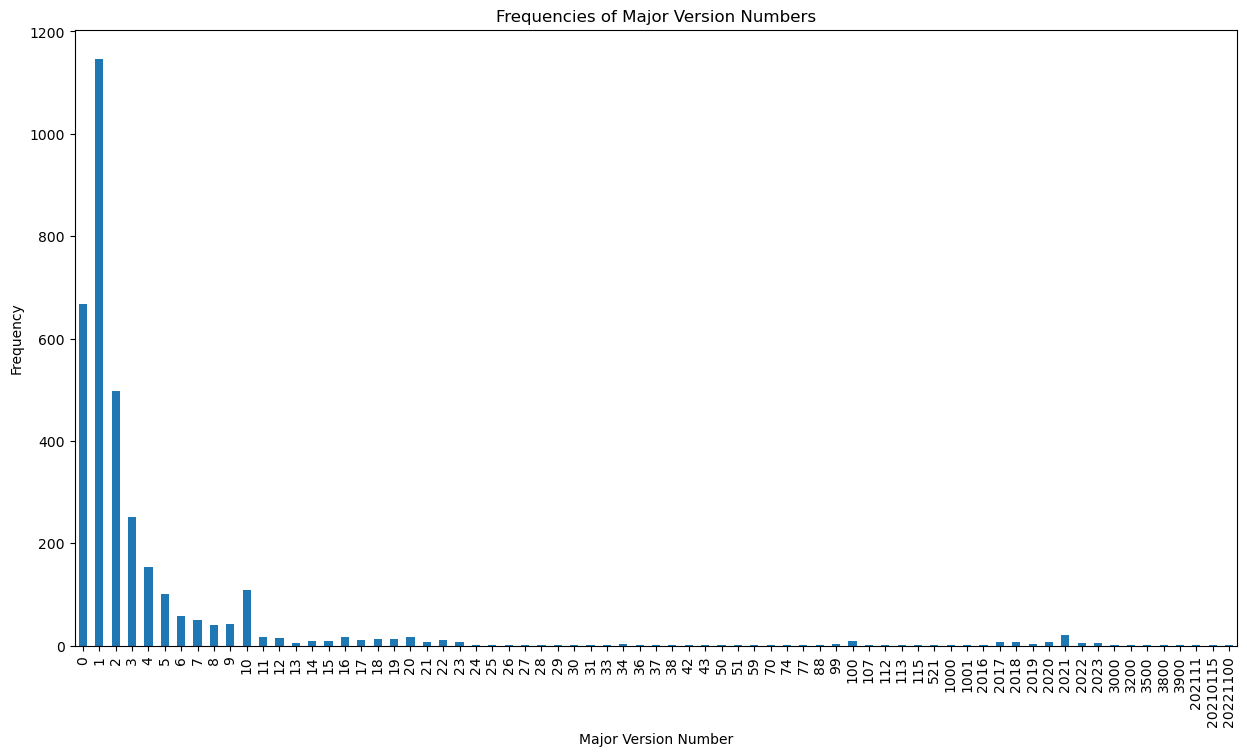

In [143]:
plt.figure(figsize=(15, 8))
major = versions[versions['major'].notna()].groupby(by=['major']).size()
major.index = major.index.astype('int')
major.plot(kind='bar')
plt.xlabel('Major Version Number')
plt.ylabel('Frequency')
plt.title('Frequencies of Major Version Numbers')
plt.show()

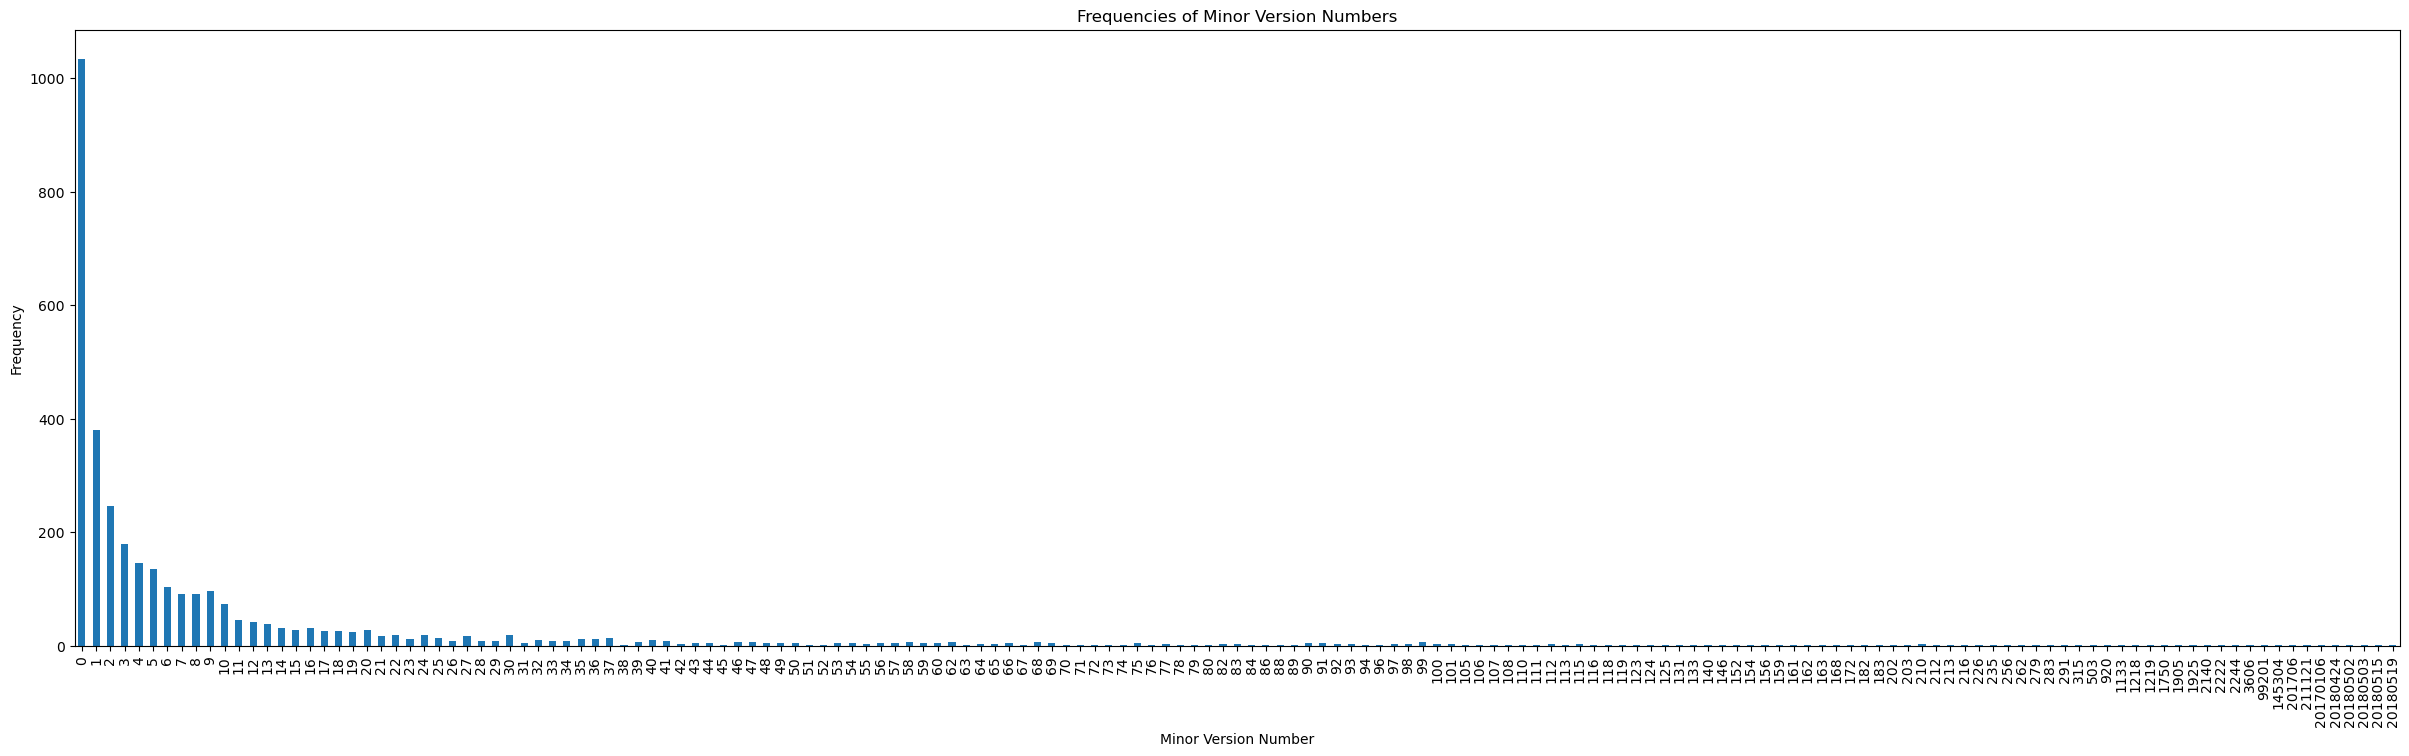

In [140]:
plt.figure(figsize=(30, 8))
major = versions[versions['minor'].notna()].groupby(by=['minor']).size()
major.index = major.index.astype('int')
major.plot(kind='bar')
plt.xlabel('Minor Version Number')
plt.ylabel('Frequency')
plt.title('Frequencies of Minor Version Numbers')
plt.show()

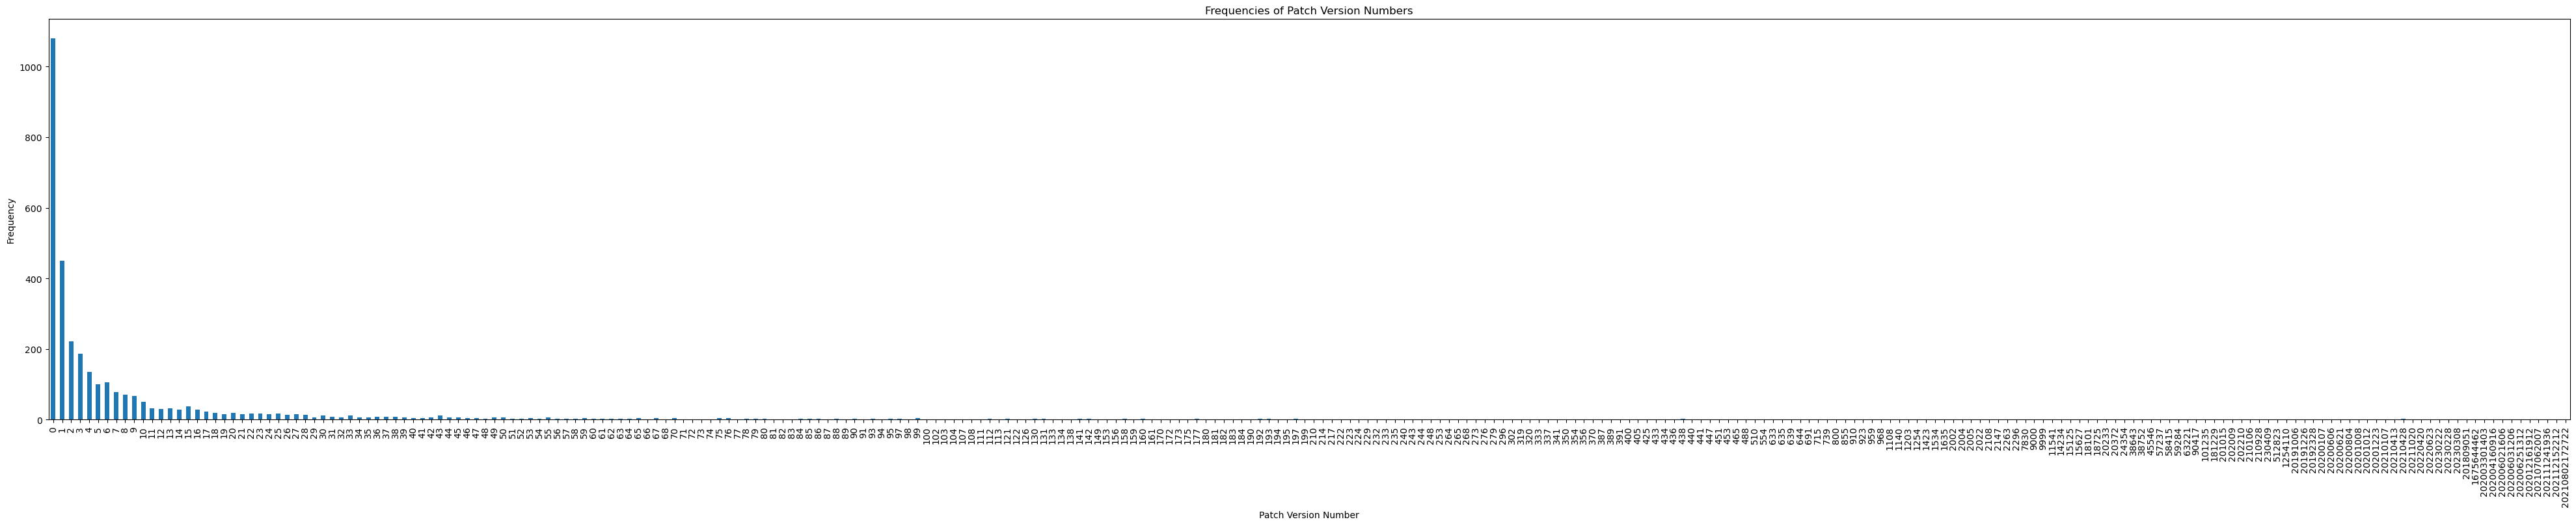

In [141]:
plt.figure(figsize=(50, 8))
major = versions[versions['patch'].notna()].groupby(by=['patch']).size()
major.index = major.index.astype('int')
major.plot(kind='bar')
plt.xlabel('Patch Version Number')
plt.ylabel('Frequency')
plt.title('Frequencies of Patch Version Numbers')
plt.show()

---

## Schemes

Here we analyze how many APIs use one or both schemes (`http`, `https`).

In [17]:
schemes = pd.DataFrame(list(swagger.find({}, { 'name': 1, '_API_spec.schemes': 1 })))

schemes['_API_spec'] = schemes['_API_spec'].apply(lambda el: '' if str(el) == '{}' else ' '.join(re.sub(r'[^\w\s]', '', str(el)).split()[1:]))
schemes['http'] = schemes['_API_spec'].str.contains('http')
schemes['https'] = schemes['_API_spec'].str.contains('https')

In [41]:
has_both = schemes[(schemes['http'] == True) & (schemes['https'] == True)]['_id'].count()
has_none = schemes[(schemes['http'] == False) & (schemes['https'] == False)]['_id'].count()
only_http = schemes[(schemes['http'] == True) & (schemes['https'] == False)]['_id'].count()

total_length = schemes['_id'].count()

In [47]:
print(f'Only `http` schema: {only_http} [{str(only_http / total_length * 100)[:3]}%]')
print(f'Both `http` and `https` schemes: {has_both} [{str(has_both / total_length * 100)[:3]}%]')
print(f'No schema: {has_none} [{str(has_none / total_length * 100)[:4]}%]')

Only `http` schema: 41730 [9.6%]
Both `http` and `https` schemes: 4367 [1.0%]
No schema: 386168 [89.3%]


In [52]:
# swagger.find({}, {'test': { '$size': { '$objectToArray': '$_API_spec.paths' } }})